In [9]:
# !pip install google-api-python-client
# !pip install google-auth google-auth-oauthlib google-auth-httplib2

# 유튜브 API를 이용한 크롤링 코드

## 소스코드

In [12]:
import csv
import os
 
import google.oauth2.credentials
 
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google_auth_oauthlib.flow import InstalledAppFlow
 
# The CLIENT_SECRETS_FILE variable specifies the name of a file that contains
# the OAuth 2.0 information for this application, including its client_id and
# client_secret.
CLIENT_SECRETS_FILE = "client_secret.json"
 
# This OAuth 2.0 access scope allows for full read/write access to the
# authenticated user's account and requires requests to use an SSL connection.
SCOPES = ['https://www.googleapis.com/auth/youtube.force-ssl']
API_SERVICE_NAME = 'youtube'
API_VERSION = 'v3'
 
 
def get_authenticated_service():
    credentials = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            credentials = pickle.load(token)
    #  Check if the credentials are invalid or do not exist
    if not credentials or not credentials.valid:
        # Check if the credentials have expired
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_console()
 
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(credentials, token)
 
    return build(API_SERVICE_NAME, API_VERSION, credentials = credentials)
 
 
def get_video_comments(service, **kwargs):
    comments = []
    results = service.commentThreads().list(**kwargs).execute()
 
    while results:
        for item in results['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)
 
        # Check if another page exists
        if 'nextPageToken' in results:
            kwargs['pageToken'] = results['nextPageToken']
            results = service.commentThreads().list(**kwargs).execute()
        else:
            break
 
    return comments
 
 
def write_to_csv(comments):
    with open('comments.csv', 'w',-1,'utf-8') as comments_file:
        comments_writer = csv.writer(comments_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        comments_writer.writerow(['Video ID', 'Title', 'Comment'])
        for row in comments:
            # convert the tuple to a list and write to the output file
            comments_writer.writerow(list(row))
 
 
def get_videos(service, **kwargs):
    final_results = []
    results = service.search().list(**kwargs).execute()
 
    i = 0
    max_pages = 3
    while results and i < max_pages:
        final_results.extend(results['items'])
 
        # Check if another page exists
        if 'nextPageToken' in results:
            kwargs['pageToken'] = results['nextPageToken']
            results = service.search().list(**kwargs).execute()
            i += 1
        else:
            break
 
    return final_results
 
 
def search_videos_by_keyword(service, **kwargs):
    results = get_videos(service, **kwargs)
    final_result = []
    for item in results:
        title = item['snippet']['title']
        video_id = item['id']['videoId']
        comments = get_video_comments(service, part='snippet', videoId=video_id, textFormat='plainText')
        # make a tuple consisting of the video id, title, comment and add the result to 
        # the final list
        final_result.extend([(video_id, title, comment) for comment in comments]) 
 
    write_to_csv(final_result)

## 실행단

In [14]:
if __name__ == '__main__':
# When running locally, disable OAuthlib's HTTPs verification. When
# running in production *do not* leave this option enabled.
    os.environ['OAUTHLIB_INSECURE_TRANSPORT'] = '1'
    service = get_authenticated_service()
    keyword = input('Enter a keyword: ')
    search_videos_by_keyword(service, q=keyword, part='id,snippet', eventType='completed', type='video')

Enter a keyword: 집값


# 시각화

In [2]:
import pandas as pd
from konlpy.tag import Mecab
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import codecs
import pytagcloud
import webbrowser
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
from bs4 import BeautifulSoup
from konlpy.tag import Twitter

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
df = pd.read_csv('comments.csv', encoding='utf-8')
comments = df['Comment']
comments

0       충청도 세종땅을 뭣같은 민주당놈들이 다 사재기해놓고 수도로 만들려고 하니간 땅값오르...
1                진짜 악의적인 기사구나 사람들이 그러면 선동된다고 생각하는 어리석은 기사
2                                         투기정부세력이 세종시로갔구만
3                    이해찬이는  세종시  집 팔고  땅 팔아서  세금 좀 내고  사소
4                          이해찬이는  세종시  집 파소   좀 부끄러운 줄 아소
                              ...                        
3972                                         그 기사 정확한 출처?
3973    재앙이 머리 돌아가는게 저 수준이라면 빨리 집을 사라는 신호. 집값 더 오르면 가짜...
3974                                          문병신 말이야 벌구야
3975    아포유님 반갑습니다.\r\n요즘 집값이 오른다고 하는데\r\n다행입니다.\r\n통계...
3976                 문산당 또 거짓말에 선전선동!\r\n할줄 아는게 저것밖에 없으니~
Name: Comment, Length: 3977, dtype: object

## 불용어 제거

In [4]:
tagger = Mecab(dicpath="C:\\mecab\\mecab-ko-dic")

stop_words = "은 이 것 등 더 를 좀 즉 인 옹 때 만 원 이때 개 일 기 시 럭 갤 성 삼 스 폰 트 드 기 이 리 폴 사 전 마 자 플 블 가 중 북 수 팩 년 월 저 탭"
stop_words = stop_words.split(' ')
stop_words[0:10]

['은', '이', '것', '등', '더', '를', '좀', '즉', '인', '옹']

In [5]:
nouns = []
for post in comments:
    for noun in tagger.nouns(post):
        if noun not in stop_words:
            nouns.append(noun)

nouns[0:10]

['충청도', '세종', '땅', '뭣', '민주당', '놈', '사재기', '수도', '땅값', '지네']

## 워드 클라우드

In [6]:
num_top_nouns = 20
nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(num_top_nouns))
print(top_nouns)

{'부동산': 705, '거': 569, '국민': 509, '미': 473, '집': 456, '집값': 440, '통': 434, '정부': 416, '주호영': 407, '사람': 347, '법': 331, '서민': 307, '국회의원': 293, '게': 271, '주택': 271, '말': 270, '돈': 259, '정책': 251, '스트레이트': 241, '놈': 239}


In [7]:
wc = WordCloud(background_color="white", font_path='./font/malgun.ttf')
wc.generate_from_frequencies(top_nouns)

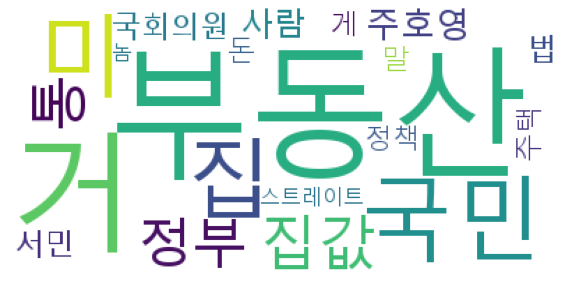

In [7]:
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(wc)

### PNG로 저장

In [8]:
def saveWordCloud(wordInfo):
    taglist = pytagcloud.make_tags(dict(wordInfo).items(), maxsize=80)
    print(type(taglist))  # <class 'list'>
    filename = 'wordcloud.png'

    pytagcloud.create_tag_image(taglist, filename, \
                                size=(640, 480), fontname='korean', rectangular=False)
    webbrowser.open(filename)

In [9]:
saveWordCloud(wordInfo)

NameError: name 'wordInfo' is not defined

## BarPlot

In [8]:
twitter=Twitter()
word_dic = {}

for line in comments:
    malist = twitter.pos(line)
    for word in malist:
        if word[1] == "Noun":  # 명사 확인하기 --- (※3)
            if not (word[0] in word_dic):
                word_dic[word[0]] = 0
            word_dic[word[0]] += 1  # 카운트하기

C:\Users\user\anaconda3\envs\kihun\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [9]:
keys = sorted(word_dic.items(), key=lambda x: x[1], reverse=True)

wordInfo = dict()
for word, count in keys[:500]:
    print("{0}({1}) ".format(word, count), end="")
    if (count > 60) and len(word) >= 2:
        wordInfo[word] = count

부동산(703) 국민(496) 것(476) 통(468) 정부(444) 집값(435) 주호영(407) 이(363) 집(352) 사람(340) 법(326) 놈(306) 투기(289) 국회의원(289) 서민(288) 주택(279) 진짜(264) 정책(247) 말(245) 돈(243) 스트레이트(242) 개(234) 그(232) 정말(228) 방송(210) 세금(208) 때(202) 정권(199) 의원(197) 위(193) 더(192) 언론(190) 인간(189) 지금(186) 아파트(180) 생각(178) 민주당(176) 나라(173) 쓰레기(172) 폭등(170) 저(167) 왜(165) 거(161) 강남(155) 니(148) 문재인(140) 채(133) 문제(133) 뭐(130) 박덕흠(130) 좀(124) 국회(124) 수(118) 유(118) 뻔(117) 통과(113) 아포(110) 위해(106) 응원(104) 미래(104) 임대(103) 탓(103) 걸(103) 서울(101) 또(101) 통합(101) 자기(100) 우리(99) 제(99) 요(98) 기자(98) 대통령(98) 저런(98) 똥(96) 보고(96) 자(96) 욕(94) 제발(93) 이제(93) 통닭(92) 하나(91) 이익(91) 이전(90) 앞(87) 입(87) 새끼(86) 건설(86) 분양(86) 해(86) 재건축(86) 모두(83) 알(82) 국(81) 내(81) 박근혜(81) 좌파(79) 때문(78) 공급(78) 대한민국(77) 정치(76) 살(76) 역시(76) 일(74) 세상(74) 보도(74) 안(73) 가지(71) 계속(71) 규제(70) 나(70) 도둑(70) 폐지(69) 장관(69) 수도(67) 이유(66) 국토(66) 못(65) 가격(64) 등(64) 배(63) 기(62) 건(61) 이상(61) 자신(61) 게(60) 환수(60) 재산(60) 지지(60) 전세(59) 정도(59) 상승(59) 그냥(59) 누가(59) 국가(59) 시장(58) 일본(58) 사업자(58) 답(5

In [10]:
def showGraph(wordInfo):
    font_location = 'c:/Windows/fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=font_location).get_name()
    matplotlib.rc('font', family=font_name)

    plt.xlabel('주요 단어')
    plt.ylabel('빈도 수')
    plt.grid(True)

    barcount = 10  # 10개만 그리겠다.

    Sorted_Dict_Values = sorted(wordInfo.values(), reverse=True)
    print(Sorted_Dict_Values)
    print('dd')
    plt.bar(range(barcount), Sorted_Dict_Values[0:barcount], align='center')

    Sorted_Dict_Keys = sorted(wordInfo, key=wordInfo.get, reverse=True)
    print(Sorted_Dict_Keys)
    plt.xticks(range(barcount), list(Sorted_Dict_Keys)[0:barcount], rotation='70')

    plt.show()

[703, 496, 444, 435, 407, 340, 289, 289, 288, 279, 264, 247, 242, 228, 210, 208, 199, 197, 190, 189, 186, 180, 178, 176, 173, 172, 170, 155, 140, 133, 130, 124, 113, 110, 106, 104, 104, 103, 101, 101, 100, 99, 98, 98, 98, 96, 93, 93, 92, 91, 91, 90, 86, 86, 86, 86, 83, 81, 79, 78, 78, 77, 76, 76, 74, 74, 71, 71, 70, 70, 69, 69, 67, 66, 66, 64, 61, 61]
dd
['부동산', '국민', '정부', '집값', '주호영', '사람', '투기', '국회의원', '서민', '주택', '진짜', '정책', '스트레이트', '정말', '방송', '세금', '정권', '의원', '언론', '인간', '지금', '아파트', '생각', '민주당', '나라', '쓰레기', '폭등', '강남', '문재인', '문제', '박덕흠', '국회', '통과', '아포', '위해', '응원', '미래', '임대', '서울', '통합', '자기', '우리', '기자', '대통령', '저런', '보고', '제발', '이제', '통닭', '하나', '이익', '이전', '새끼', '건설', '분양', '재건축', '모두', '박근혜', '좌파', '때문', '공급', '대한민국', '정치', '역시', '세상', '보도', '가지', '계속', '규제', '도둑', '폐지', '장관', '수도', '이유', '국토', '가격', '이상', '자신']


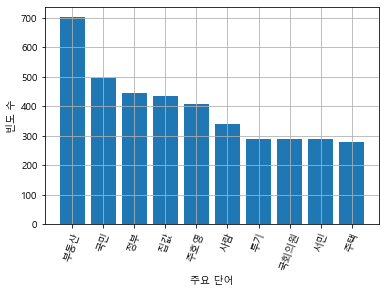

In [11]:
showGraph(wordInfo)

# BoW 분석

In [12]:
from konlpy.tag import Okt

In [13]:
list(wordInfo.keys())[0:10]

['부동산', '국민', '정부', '집값', '주호영', '사람', '투기', '국회의원', '서민', '주택']

In [14]:
words=list(wordInfo.keys())[0:10]
word_to_index = {}

for i,word in enumerate(words):
    word_to_index[word]=i

In [15]:
word_to_index

{'부동산': 0,
 '국민': 1,
 '정부': 2,
 '집값': 3,
 '주호영': 4,
 '사람': 5,
 '투기': 6,
 '국회의원': 7,
 '서민': 8,
 '주택': 9}

In [16]:
def convert_bow(sentence, word_to_index):
    
    # 벡터를 단어의 개수만큼 0으로 초기화
    vector = [0]*(len(word_to_index))

    # 문장을 토큰으로 분리
    tokenizer = Okt()
    tokens = tokenizer.morphs(sentence)
    
    # 단어의 인덱스 위치에 1 설정
    for token in tokens:
        if token in word_to_index.keys():
            vector[word_to_index[token]] += 1
    
    return vector

In [17]:
print(list(word_to_index.items()))
for i in range(20):
    print(i+1,df['Comment'][i])
    print(convert_bow(df['Comment'][i],word_to_index),'\n')

[('부동산', 0), ('국민', 1), ('정부', 2), ('집값', 3), ('주호영', 4), ('사람', 5), ('투기', 6), ('국회의원', 7), ('서민', 8), ('주택', 9)]
1 충청도 세종땅을 뭣같은 민주당놈들이 다 사재기해놓고 수도로 만들려고 하니간 땅값오르고 오르고나면 지네들끼리 다 해쳐먹기좋으니 .
대단한 희대의 사기꾼놈들이다 민즈재앙당
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

2 진짜 악의적인 기사구나 사람들이 그러면 선동된다고 생각하는 어리석은 기사
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0] 

3 투기정부세력이 세종시로갔구만
[0, 0, 1, 0, 0, 0, 1, 0, 0, 0] 

4 이해찬이는  세종시  집 팔고  땅 팔아서  세금 좀 내고  사소
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

5 이해찬이는  세종시  집 파소   좀 부끄러운 줄 아소
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

6 토론이  너무 부정적 이네요
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

7 뱀껍질을 덮어쓴 인간들
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

8 왜 이직도 전세 운운하냐 겝투기의 원흉이 되어버린 후진국 경제지원짹  전세 지원제도  월세 지원책으로 바꿔야 한다  전세 5억 지원하나 월세금 250에 일부 지원하나 정부에서 부동산 세금으로 충분하다  뭘 겝투기의 원흉인 전세가지고  집주인이 전세금 올린다고 겁주는지
[1, 0, 1, 0, 0, 0, 0, 0, 0, 0] 

9 저 의원들놈들얼굴에 똥물을 확 끼얹고 싶네~~
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

10 ㅅㅍ 놈들 경기 침체 푼다고 돈조금 풀어생색 내고 세금폭탄 터트리는 놈들 하나도 반갑지도 않다 ~~
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

11 세종시 천도는 엄청난  돈을 벌 수 있는 투기장이 될것이다. 미리 정보를 알고 있는 여권은 

상위 10개 noun을 이용한 BoW 구성해보았다

# TF-IDF

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
tf_idf = TfidfVectorizer()
tf_idf_matrix = tf_idf.fit_transform(df['Comment'])

In [40]:
print(tf_idf_matrix[0])

  (0, 10625)	0.2583198668267692
  (0, 13071)	0.2583198668267692
  (0, 27740)	0.23078229438781173
  (0, 6765)	0.21665712806592327
  (0, 27050)	0.2583198668267692
  (0, 23225)	0.2583198668267692
  (0, 17909)	0.2583198668267692
  (0, 8045)	0.2583198668267692
  (0, 26413)	0.2583198668267692
  (0, 8624)	0.2253029275201279
  (0, 14759)	0.24613429690055086
  (0, 13336)	0.2583198668267692
  (0, 10580)	0.24613429690055086
  (0, 10254)	0.2583198668267692
  (0, 14426)	0.2583198668267692
  (0, 24814)	0.24613429690055086


상당히 sparse한 matrix가 생성된 것을 확인할 수 있었다.

In [21]:
len(df)

3977

In [22]:
tf_idf_matrix.shape

(3977, 27822)

# Word2Vec

In [23]:
import gensim.models
from gensim.models import Word2Vec

In [24]:
okt = Okt()
tokenized_data = []
for sentence in df['Comment']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
    tokenized_data.append(temp_X)

In [25]:
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [26]:
model.wv.vectors.shape

(2343, 100)

## 각각의 단어들과 유사한 단어들 출력

In [27]:
print(model.wv.most_similar("집값"))

[('가격', 0.9994532465934753), ('박근혜', 0.999419093132019), ('정권', 0.999417245388031), ('에서', 0.9993950128555298), ('값', 0.9993623495101929), ('규제', 0.9993098378181458), ('노무현', 0.9992594122886658), ('재건축', 0.9992466568946838), ('상승', 0.9992166757583618), ('분양', 0.9992058873176575)]


In [28]:
print(model.wv.most_similar("부동산"))

[('만들다', 0.9969976544380188), ('통과', 0.9954630732536316), ('2014년', 0.9948153495788574), ('정책', 0.9942560195922852), ('시키다', 0.9942318201065063), ('악법', 0.9939833283424377), ('허용', 0.9939370155334473), ('3', 0.9938729405403137), ('찬성', 0.9936267137527466), ('동', 0.9935228228569031)]


집값에 대한 단어들이 latent space에서 한 곳에 밀집 되어 이렇게 단어들의 similarity가 높게 나왔다고 생각한다. 다양한 감정들이 나올 수 있는 주제라면 similarity가 떨어질 것이라고 예상된다.

## '부동산'과'만들다'의 벡터값 출력

In [34]:
model["부동산"]

C:\Users\user\anaconda3\envs\kihun\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.1506607 ,  0.09421591, -0.25584114, -0.3713538 , -0.66435933,
        0.4903391 ,  0.13691643, -0.04894613, -0.17559825,  0.6842547 ,
       -0.7257693 , -0.2934813 , -0.1152133 ,  0.13788307,  0.50816804,
       -0.22307049,  0.3826865 ,  0.1610581 , -0.5594693 ,  0.16854838,
       -0.35279292,  0.01597704, -0.35904983, -0.00386442,  0.31756723,
        0.01379807,  0.45884743, -0.47077084, -0.3156501 ,  0.67499083,
       -0.4131597 ,  0.16890945,  0.17922333,  0.677276  , -0.08623117,
       -0.30649433, -0.24535944, -0.47971445, -0.03639056,  0.13071772,
       -0.33569622,  0.03727746, -0.00459181,  0.31350234,  0.15483789,
       -0.46201357, -0.36760923,  0.02079497, -0.35126325,  0.00374359,
       -0.80272824, -0.207523  , -0.33292937,  0.06653403, -0.30096245,
       -0.13763039, -0.27503058, -0.42784417,  0.09720705, -0.20008619,
       -0.21310928,  0.06071185,  0.46752903,  0.2021393 ,  0.6441843 ,
       -0.5057664 , -0.07220303,  0.41001537, -0.03437722, -0.34

In [42]:
model["만들다"]

C:\Users\user\anaconda3\envs\kihun\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.1573793 ,  0.07654826, -0.2053213 , -0.37953675, -0.6574072 ,
        0.484092  ,  0.1407021 , -0.03811075, -0.1557571 ,  0.63627905,
       -0.6810674 , -0.28704822, -0.10011229,  0.16538627,  0.5091624 ,
       -0.210848  ,  0.38180864,  0.1504759 , -0.52975094,  0.16759445,
       -0.37958312,  0.04995519, -0.36195818, -0.02761775,  0.332446  ,
        0.05722291,  0.40694514, -0.45204672, -0.2943794 ,  0.6347665 ,
       -0.41691273,  0.19175136,  0.17284903,  0.6174666 , -0.09134376,
       -0.30462497, -0.2512189 , -0.45222503,  0.00388669,  0.10463777,
       -0.28084433, -0.00483885,  0.00611481,  0.36233333,  0.17690395,
       -0.40902832, -0.35775635,  0.03364113, -0.35309806, -0.01162454,
       -0.80951583, -0.19902918, -0.3031773 ,  0.04895581, -0.32601944,
       -0.081614  , -0.2734323 , -0.44437912,  0.06600741, -0.22181647,
       -0.22967367,  0.09285848,  0.4113244 ,  0.17854609,  0.64803344,
       -0.48549315, -0.06599905,  0.3488154 , -0.04148808, -0.32